[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hpcgarage/pyboot-g2s3/blob/master/supplemental/market.ipynb)

# Exercises: Market-clearing prices

## (Sample solutions)

In this problem, you will simulate a simple economic market of buyers and sellers who wish to trade a certain product. This problem assesses your ability to translate a procedure into efficient code using elementary Python. There are two (2) exercises worth a total of ten (10) points.

This notebook includes some simple plots to help you understand and debug the output. Run the cell below now, which will define the plotting routines. (You do not need to understand the code inside this cell.)

> The test cells in this file compare against data that is included in the repository containing this code. If you are running in some environment (e.g., Google Colab) and need this data, it is available here: https://cse6040.gatech.edu/datasets/market.zip

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Adapted from: https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html
def autolabel(rects, xpos='center', ax=None):
    if ax is None:
        ax = plt.gca()
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')

def viz_market(market):
    x = range(len(market))
    y = [p for _, p in market]
    is_buyer = [t == 'buyer' for t, _ in market]
    colors = ['blue' if is_blue else 'gray' for is_blue in is_buyer]

    def split_filter(x, f):
        x_true = [xi for xi, fi in zip(x, f) if fi]    
        x_false = [xi for xi, fi in zip(x, f) if not fi]
        return x_true, x_false

    x_buyers, x_sellers = split_filter(x, is_buyer)
    y_buyers, y_sellers = split_filter(y, is_buyer)

    buyer_bars = plt.bar(x_buyers, y_buyers, color='blue', label='buyers')
    seller_bars = plt.bar(x_sellers, y_sellers, color='lightgray', label='sellers')
    plt.xlabel('Person ID')
    plt.title('Price ($)')
    plt.legend()
    autolabel(buyer_bars)
    autolabel(seller_bars)
    
def fn(fn_base, dirname='./market-data/'):
    from os.path import isdir
    assert isdir(dirname)
    return '{}{}'.format(dirname, fn_base)

## A simple economic market

Consider the following model of an **_(economic) market_**.

**Sellers and buyers.** Suppose there are $n$ people, who wish to trade some product, like coffee mugs. The people come in two types: **_sellers_**, who have a coffee mug and wish to sell it, and **_buyers_**, who do not have coffee mugs but wish to acquire one.

**Product values and prices.** Each person values a coffee mug differently. That means each seller wants to sell his or her coffee mug at one price, while each buyer wants to buy at (possibly) some other price. These prices might differ from person to person, that is, different sellers want to sell at different prices, and similarly for buyers.

**Example.** Suppose $n=13$ people, of whom $n_s=9$ are sellers and $n_b=4$ buyers. Each seller and buyer values the product, a single coffee mug, at some price.

The code cell below defines this market, which is stored in a list named `market_demo`. Each person `i` is represented by `market_demo[i] = (who_i, price_i)`, a tuple where `who_i` is either `'seller'` or `'buyer'`, and `price_i` is the value that person `i` has assigned to a coffee mug that he or she wishes to sell or buy.

Run this code cell now to "create" this market.

[('seller', 1.5), ('seller', 2.0), ('seller', 1.0), ('seller', 1.5), ('seller', 4.5), ('seller', 1.0), ('seller', 3.5), ('seller', 3.0), ('buyer', 2.0), ('buyer', 2.0), ('buyer', 3.5), ('seller', 2.5), ('buyer', 1.0)]


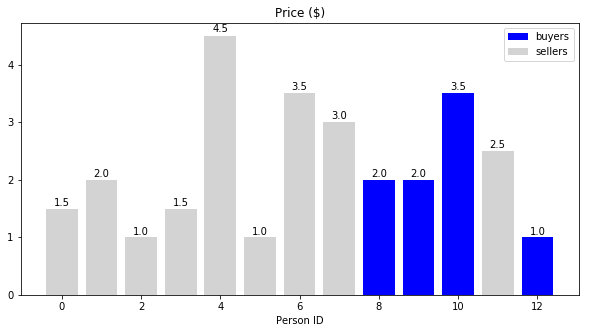

In [2]:
market_demo = [('seller', 1.5), ('seller', 2.0), ('seller', 1.0),
               ('seller', 1.5), ('seller', 4.5), ('seller', 1.0),
               ('seller', 3.5), ('seller', 3.0), ('buyer', 2.0),
               ('buyer', 2.0), ('buyer', 3.5), ('seller', 2.5),
               ('buyer', 1.0)]

print(market_demo)
plt.figure(figsize=(10, 5))
viz_market(market_demo)

Observe that there are 9 sellers, shown as light gray bars, and 4 buyers, shown as darker blue bars. Each bar is labeled by the corresponding person's price. For example, persons 0 and 3 wish to sell their coffee mugs for `$1.50`, whereas person 10 is willing to pay `$3.50`, while person 12 is only willing to pay `$1.00`.

## The market-clearing price

Now suppose buyers and sellers start trading their coffee mugs, according to the following procedure:

1. Initially, all buyers and sellers are "unmatched."
2. Pick any unmatched buyer with the highest price. Similarly, pick any unmatched seller with the lowest price.
3. A **_match_** occurs between these two **if** the buyer's price is at least as large as the seller's price. If there is a match, they exchange coffee mugs. This transaction is also called a **_trade_**. Once these two people have executed this trade, they are no longer part of the market.
4. Repeat this matching process (steps 2 and 3) among the remaining buyers and sellers, until no matches remain.

> What if there is a tie, meaning there are multiple unmatched buyers with the same highest price or multiple unmatched sellers with the same lowest price? In this case, the buyer or seller is selected arbitrarily.

For instance, go back to the `market_demo` example.
- Initially, there are no matches.
- The buyer with the highest price is Person 10, whose value is `$3.50`.
- There are two sellers with the same lowest price, Persons 2 and 5, who both value coffee mugs at `$1.00`. Pick either one; let's say, Person 2. Thus, Persons 10 and 2 are "matched." They drop out of the market.
- Among remaining buyers, both Persons 8 and 9 have the highest price, who each have a value of `$2.00`. So one of these will be matched against Person 5; let's say it's Person 8. Persons 5 and 8 are matched and drop out.
- Then Person 9 will be matched against either Persons 0 or 3, who have the same price of `$1.50`; let's say it's Person 0.

Here is what we have so far:

| Buyer \$ | Seller \$ |        Who?        |
|:--------:|:---------:|:------------------:|
|   3.5    |    1.0    | $10 \Leftarrow 2$  |
|   2.0    |    1.0    |  $8 \Leftarrow 5$  |
|   2.0    |    1.5    |  $9 \Leftarrow 0$  |

As it happens, that is the last possible trade in this market! Person 12 is the only unmatched buyer, but his or her value is only `$1.00`. By contrast, the next unmatched seller is Person 3 with a value of `$1.50`. Since the asking price of `$1.50` exceeds the buyer's price of `$1.00`, they cannot trade. We say the market has **reached equilibrium.**

**The (market-)clearing price**. Looking at the trades, consider the highest selling price, which in the preceding example was `$1.50`. We refer to this value as the **_market-clearing price_**, or just **_clearing price_**: it is the selling price at which the market has reached an equilibrium and no further trades are possible.

> There are other possible definitions of clearing price, but for this problem, please use this one.

## Exercises

**Exercise 0** (2 points). You do not need to write any code in this exercise. However, you do need to read some code, for which you get a "almost-free" 2 points! (You **must** submit the problem to the autograder to get these two points.)

To help you get started, we are giving you one function called `p, n = analyze_market(m)` that implements the procedure above. Given a market `m`, it returns two values: the clearing price `p` and the number of trades `t`. If no trades are possible at all, it returns `p=0` and `t=0` (both integers, even though `p` could be fractional in general).

Read the code for `analyze_market()` and convince yourself that it implements the trading procedure described previously. As a reminder (and to save you some scrolling), here is that trading procedure, repeated verbatim:

1. Initially, all buyers and sellers are "unmatched."
2. Pick any unmatched buyer with the highest price. Similarly, pick any unmatched seller with the lowest price.
3. A **_match_** occurs between these two **if** the buyer's price is at least as large as the seller's price. If there is a match, they exchange coffee mugs. This transaction is also called a **_trade_**. Once these two people have executed this trade, they are no longer part of the market.
4. Repeat this matching process (steps 2 and 3) among the remaining buyers and sellers, until no matches remain.

> What if there is a tie, meaning there are multiple unmatched buyers with the same highest price or multiple unmatched sellers with the same lowest price? In this case, the buyer or seller is selected arbitrarily.

In [3]:
# Test cell: `ex0_freebie` (2 points)

def analyze_market(market, verbose=False):
    buy_prices = [price for who, price in market if who == 'buyer']
    sell_prices = [price for who, price in market if who == 'seller']
    trades = [] # Tracks trades
    unmatched = buy_prices and sell_prices
    while unmatched:
        i_buyer = buy_prices.index(max(buy_prices))
        i_seller = sell_prices.index(min(sell_prices))
        if buy_prices[i_buyer] >= sell_prices[i_seller]: # A match!
            trades.append((buy_prices[i_buyer], sell_prices[i_seller]))
            del buy_prices[i_buyer]
            del sell_prices[i_seller]
            unmatched = buy_prices and sell_prices
        else:
            unmatched = False # Stops trading
    if verbose: print(trades)
    if trades:
        return trades[-1][1], len(trades)
    return int(0), int(0)

clearing_price_demo, num_trades_demo = analyze_market(market_demo, verbose=True)
print("The clearing price is ${:.2f}.".format(clearing_price_demo))
print("There were {} trades.".format(num_trades_demo))

print("\n(Passed!)")

[(3.5, 1.0), (2.0, 1.0), (2.0, 1.5)]
The clearing price is $1.50.
There were 3 trades.

(Passed!)


**Creating a random market.** For the next few exercises, we'll need a function that can create a random market.

The function `create_random_market(num_people, prob_buyer, max_price)` will randomly generate a market in the form of a list of tuples formatted just like `market_demo`, above. Its parameters are:

- `num_people`: The number of people in the market
- `prob_buyer`: The probability that a given person should be a buyer, rather than a seller.
- `max_price`: The maximum value that can be assigned to any buyer or seller.

Each value (price) will be an integer drawn uniformly at random from the _closed_ interval `[1, max_price]`, that is, inclusive of 1 and `max_price`.

Recall that `market_demo` looked like the following (run the next cell):

In [4]:
print(market_demo)

[('seller', 1.5), ('seller', 2.0), ('seller', 1.0), ('seller', 1.5), ('seller', 4.5), ('seller', 1.0), ('seller', 3.5), ('seller', 3.0), ('buyer', 2.0), ('buyer', 2.0), ('buyer', 3.5), ('seller', 2.5), ('buyer', 1.0)]


And here is the `create_random_market` function; as a quick demo, run it a few times.

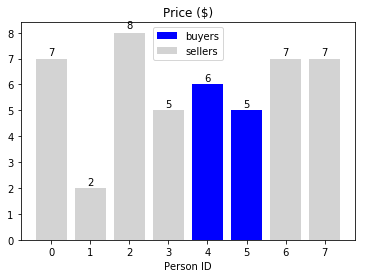

In [5]:
def random_person(prob_buyer, max_price):
    from random import uniform, randrange
    who = 'buyer' if uniform(0, 1) < prob_buyer else 'seller'
    price = randrange(1, max_price+1)
    return (who, price)

def create_random_market(num_people, prob_buyer, max_price):
    return [random_person(prob_buyer, max_price) for _ in range(num_people)]

# Demo:
market_demo2 = create_random_market(8, 0.3, 10)
viz_market(market_demo2)

**Exercise 1** (2 points). Next, you will implement a function that simulates market trading.

In particular, you will define this function:

```python
def simulate(prob_buyer, num_people, max_price, num_trials):
    ...
```

One input is `num_trials`, which is the number of simulation trials to run. In each trial, your code should:

- Randomly generate a market with `num_people` people, where the probability of being a buyer is `prob_buyer` and the maximum price for any buyer or seller is `max_price`, drawn uniformly at random from 1 to `max_price`, inclusive. _Hint: Use a function that appears earlier in this notebook._
- Call `analyze_market()` to analyze that market.
- Record the clearing price and number of trades as a tuple (pair).
- Return all of these pairs in a list.

For example,

```python
    simulate(0.5, 8, 10, 5)
```

might return the list of pairs, `[(10, 2), (3, 3), (10, 2), (9, 1), (15, 2)]`, which has one entry per trial and 5 trials in all, and each entry is a (clearing price, number of trades) pair. (This is just an example of the format of the output; since the markets will be generated randomly, you will see different values.)

There are two test cells, so you can get partial credit. The first is just a quick demo; if your simulation is on the right track, you should see that when there are many more sellers than buyers, then the clearing price is low; and in the opposite scenario, the clearing price will be high.

In [ ]:
'''def simulate(prob_buyer, num_people, max_price, num_trials):
    market_demo3 = create_random_market(num_people, prob_buyer, max_price)
    while True:
        clearing_price_demo, num_trades_demo = analyze_market(market_demo3, verbose=True)
        if num_trades_demo == num_trials:
            break
        else:
            market_demo3 = create_random_market(num_people, prob_buyer, max_price)

simulate(0.5, 10, 10, 5)'''

In [6]:
def simulate(prob_buyer, num_people, max_price, num_trials):
    list = []
    counter = 0
    while True:
        market_demo3 = create_random_market(num_people, prob_buyer, max_price)
        clearing_price_demo, num_trades_demo = analyze_market(market_demo3, verbose=False)
        a = (clearing_price_demo, num_trades_demo)
        list.append(a)
        counter+=1
        if counter >= num_trials:
            break    
    
    return list

print(simulate(0.5, 8, 10, 5))

[(7, 2), (4, 3), (5, 2), (3, 3), (5, 3)]



Consider a market of 100 people, of whom about 10 are buyers on average.
Suppose a given product is worth at most $10 to any buyer or seller.
Then, 1000 trials of your simulation suggests that ...

* the average clearing price is $1.501; and
* the average number of trades is 9.493.

Consider a market of 100 people, of whom about 90 are buyers on average.
Suppose a given product is worth at most $10 to any buyer or seller.
Then, 1000 trials of your simulation suggests that ...

* the average clearing price is $8.902; and
* the average number of trades is 9.435.

Consider a market of 100 people, of whom about 50 are buyers on average.
Suppose a given product is worth at most $10 to any buyer or seller.
Then, 1000 trials of your simulation suggests that ...

* the average clearing price is $5.43; and
* the average number of trades is 25.918.

(Passed!)


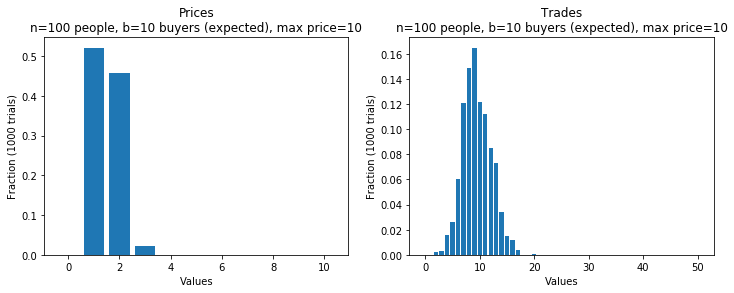

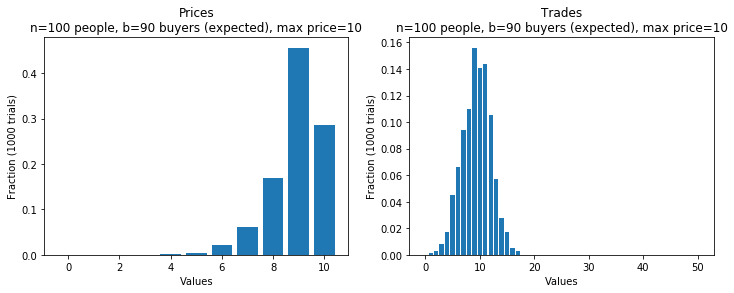

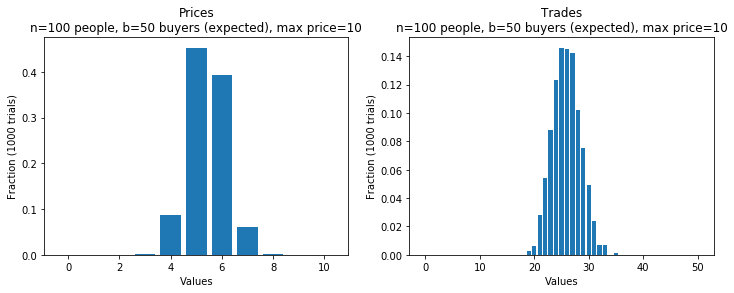

In [7]:
# Test cell 0: `ex1_0_quick_run` (1 point)

def avg_clearing_price(sim_results):
    return sum([price for price, _ in sim_results]) / len(sim_results)

def avg_trades(sim_results):
    return sum([trades for _, trades in sim_results]) / len(sim_results)

def viz_counts(values, counts, norm=True, ax=None, title=''):
    if ax is None: ax = plt.gca()
    if norm:
        s = sum(counts)
        y = [c/s for c in counts]
    else:
        y = counts
    bars = ax.bar(values, y)
    ax.set_xlabel('Values')
    ax.set_ylabel('Fraction ({} trials)'.format(s) if norm else 'Counts')
    ax.set_title(title)
    return bars

def get_counts_sorted_by_value(x, values=None):
    from collections import Counter
    counts_table = Counter(x)
    if values is None:
        pairs = sorted(counts_table.items(), key=lambda x: x[0])
        values = [v for v, _ in pairs]
        counts = [c for _, c in pairs]
    else:
        values = list(values)
        counts = [counts_table.get(v, 0) for v in values]
    return values, counts
    
NUM_PEOPLE = 100
MAX_PRICE = 10
NUM_TRIALS = 1000
CASES__AVG_BUYERS = [10, 90, 50]
all_results = []
for avg_buyers in CASES__AVG_BUYERS:
    results = simulate(avg_buyers/NUM_PEOPLE, NUM_PEOPLE, MAX_PRICE, NUM_TRIALS)
    print("""
==================================================
Consider a market of {} people, of whom about {} are buyers on average.
Suppose a given product is worth at most ${} to any buyer or seller.
Then, {} trials of your simulation suggests that ...
""".format(NUM_PEOPLE, avg_buyers, MAX_PRICE, NUM_TRIALS))
    print("* the average clearing price is ${}; and".format(avg_clearing_price(results)))
    print("* the average number of trades is {}.".format(avg_trades(results)))
    all_results.append(results)
    price_values, price_counts = get_counts_sorted_by_value([p for p, _ in results],
                                                            values=range(0, MAX_PRICE+1))
    trade_values, trade_counts = get_counts_sorted_by_value([t for _, t in results],
                                                            values=range(0, (NUM_PEOPLE+2)//2))

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    subtitle = '\nn={} people, b={} buyers (expected), max price={}'.format(NUM_PEOPLE, avg_buyers, MAX_PRICE)
    viz_counts(price_values, price_counts, ax=ax[0], title='Prices{}'.format(subtitle))
    viz_counts(trade_values, trade_counts, ax=ax[1], title='Trades{}'.format(subtitle))
    
print("\n(Passed!)")

In [8]:
# Test cell: `ex1_1_random_tests` (1 point)

def check_dist(dist, obs, title=None):
    from scipy.stats import kstest, ks_2samp
    from numpy import array
    exp_obs = []
    for v, c in zip(dist.index, dist['freq']):
        exp_obs += [v] * int(c * len(obs))
    D, p = ks_2samp(obs, array(exp_obs))
    if title is not None: # Verbose mode
        print("{}: D={}, p={}".format(title, D, p))
    assert p > 0.1, "There is something fishy about the values produced by your simulation. Keep trying! (D={}, p={})".format(D, p)
    
def read_dist(filepath):
    from pandas import read_csv
    pmf = read_csv(filepath)
    cdf = pmf.set_index('value')
    cdf['cfreq'] = cdf['freq'].cumsum()
    return cdf

def check_sim_results(avg_buyers, results, title=None):
    prices_dist = read_dist(fn('prices--n{}--eb{}--p{}.csv'.format(NUM_PEOPLE, avg_buyers, MAX_PRICE)))
    prices_obs = [p for p, _ in results]
    check_dist(prices_dist, prices_obs, title)
    
    trades_dist = read_dist(fn('trades--n{}--eb{}--p{}.csv'.format(NUM_PEOPLE, avg_buyers, MAX_PRICE)))
    trades_obs = [t for _, t in results]
    check_dist(trades_dist, trades_obs, title)

NUM_PEOPLE = 100
MAX_PRICE = 10
NUM_TRIALS = 1000
CASES__AVG_BUYERS = [10, 90, 50]
    
for avg_buyers in CASES__AVG_BUYERS:
    results = simulate(avg_buyers/NUM_PEOPLE, NUM_PEOPLE, MAX_PRICE, NUM_TRIALS)
    assert len(results) == NUM_TRIALS, "Did not return the correct number of results."
    check_sim_results(avg_buyers, results, title='avg_buyers={}'.format(avg_buyers))
    
print("\n(Passed!)")

avg_buyers=10: D=0.007909819639278615, p=0.9999999999999997
avg_buyers=10: D=0.023612512613521708, p=0.9416827538586781
avg_buyers=90: D=0.02199598393574298, p=0.9675937388500755
avg_buyers=90: D=0.02952419354838709, p=0.7723355757594776
avg_buyers=50: D=0.011423269809428316, p=0.9999999281097212
avg_buyers=50: D=0.013489404641775976, p=0.9999883003859598

(Passed!)


**Timing.** Let's measure how long it takes to run `analyze_market()` for a "large" market, i.e., one with many people.

In [9]:
market_for_timing = create_random_market(20000, 0.5, 100)
%timeit analyze_market(market_for_timing)

1.54 s ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Exercise 2** (6 points). The `analyze_market()` function is slow. Come up with a more efficient implementation.

There will be both a correctness test (1 point) and a timing test (5 points). The timing test below will check that your implementation is at least **50 times faster** than `analyze_market()` on an input comparable to `market_for_timing`, as generated above. There is no partial credit for anything that does not beat this threshold.

> _Hint._ You may be tempted to start with the `analyze_market()` but replace lists with Numpy arrays. While that may work (we didn't try it), our sample solution handily beats the target threshold using only standard Python (no Numpy!) but with a better algorithm. In particular, rather than literally implementing the trading procedure, as `analyze_market()` does, see if you can find a different way to perform the same analysis.

In [10]:
# Taken from https://github.com/amirziai/learning/blob/master/algorithms/Merge-Sort.ipynb
def split(input_list):
    """
    Splits a list into two pieces
    :param input_list: list
    :return: left and right lists (list, list)
    """
    input_list_len = len(input_list)
    midpoint = input_list_len // 2
    return input_list[:midpoint], input_list[midpoint:]

In [11]:
def merge_sorted_lists(list_left, list_right):
    """
    Merge two sorted lists
    This is a linear operation
    O(len(list_right) + len(list_right))
    :param left_list: list
    :param right_list: list
    :return merged list
    """
    # Special case: one or both of lists are empty
    if len(list_left) == 0:
        return list_right
    elif len(list_right) == 0:
        return list_left
    
    # General case
    index_left = index_right = 0
    list_merged = []  # list to build and return
    list_len_target = len(list_left) + len(list_right)
    while len(list_merged) < list_len_target:
        if list_left[index_left] <= list_right[index_right]:
            # Value on the left list is smaller (or equal so it should be selected)
            list_merged.append(list_left[index_left])
            index_left += 1
        else:
            # Right value bigger
            list_merged.append(list_right[index_right])
            index_right += 1
            
        # If we are at the end of one of the lists we can take a shortcut
        if index_right == len(list_right):
            # Reached the end of right
            # Append the remainder of left and break
            list_merged += list_left[index_left:]
            break
        elif index_left == len(list_left):
            # Reached the end of left
            # Append the remainder of right and break
            list_merged += list_right[index_right:]
            break
        
    return list_merged

In [12]:
def merge_sort(input_list):
    if len(input_list) <= 1:
        return input_list
    else:
        left, right = split(input_list)
        # The following line is the most important piece in this whole thing
        return merge_sorted_lists(merge_sort(left), merge_sort(right))

In [19]:
buy_prices = [price for who, price in market_demo if who == 'buyer']
print(buy_prices, type(buy_prices))
print(sorted(buy_prices))

[2.0, 2.0, 3.5, 1.0] <class 'list'>
[1.0, 2.0, 2.0, 3.5]


In [20]:
def analyze_market_faster(market, verbose=False):
    buy_prices = [price for who, price in market if who == 'buyer']
    sell_prices = [price for who, price in market if who == 'seller']
    trades = [] # Tracks trades
    #sorted_buyer = merge_sort(buy_prices)
    #sorted_seller = merge_sort(sell_prices)
    sorted_buyer = sorted(buy_prices)
    sorted_seller = sorted(sell_prices)
    unmatched = sorted_buyer and sorted_seller
    while unmatched:
        if sorted_buyer[-1] >= sorted_seller[0]: # A match!
            trades.append((sorted_buyer[-1], sorted_seller[0]))
            del sorted_buyer[-1]
            del sorted_seller[0]
            unmatched = sorted_buyer and sorted_seller
        else:
            unmatched = False # Stops trading
    if verbose: print(trades)
    if trades:
        return trades[-1][1], len(trades)
    return int(0), int(0)
    ###
    ### YOUR CODE HERE
    ###
    
clearing_price0, trades0 = analyze_market(market_demo, verbose=True)
clearing_price1, trades1 = analyze_market_faster(market_demo, verbose=True)
print("Baseline: The clearing price is ${} with {} trades.".format(clearing_price0, trades0))
print("Your method: The clearing price is ${} with {} trades.".format(clearing_price1, trades1))

[(3.5, 1.0), (2.0, 1.0), (2.0, 1.5)]
[(3.5, 1.0), (2.0, 1.0), (2.0, 1.5)]
Baseline: The clearing price is $1.5 with 3 trades.
Your method: The clearing price is $1.5 with 3 trades.


In [21]:
# This code cell times your method and is here for debugging purposes
%timeit analyze_market_faster(market_for_timing)

13.5 ms ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The following two cells are the tests for Exercise 2 that you must pass to get points.

In [22]:
# Test cell 0: `analyze_market_faster_correctness` (1 point)
import random

print("Checking corner cases...")
assert analyze_market([]) == analyze_market_faster([])
assert analyze_market([(1, 'buyer')]) == analyze_market_faster([(1, 'buyer')])
assert analyze_market([(1, 'seller')]) == analyze_market_faster([(1, 'seller')])

print("Checking random cases...")
for trial_num in range(1, 11): # 10 random trials
    num_people_for_testing = random.randrange(1, 10)
    avg_buyers_for_testing = random.randrange(num_people_for_testing+1)
    prob_buyer_for_testing = avg_buyers_for_testing / num_people_for_testing
    max_price_for_testing = random.randrange(5, 20)
    print("Trial {}: {} people, {} buyers (expected; prob={}), max price of ${}".format(trial_num,
                                                                                        num_people_for_testing,
                                                                                        avg_buyers_for_testing,
                                                                                        prob_buyer_for_testing,
                                                                                        max_price_for_testing))
    market_for_testing = create_random_market(num_people_for_testing, prob_buyer_for_testing, max_price_for_testing)
    naive_result = analyze_market(market_for_testing)
    your_result = analyze_market_faster(market_for_testing)
    assert your_result == naive_result, "Results do not match on this market (`market_for_testing`):\n\t{}.\nYour result is {} while the baseline produces {}.".format(market_for_testing, your_result, naive_result)
    
print("\n(Passed!)")

Checking corner cases...
Checking random cases...
Trial 1: 4 people, 3 buyers (expected; prob=0.75), max price of $16
Trial 2: 2 people, 0 buyers (expected; prob=0.0), max price of $5
Trial 3: 2 people, 0 buyers (expected; prob=0.0), max price of $7
Trial 4: 5 people, 3 buyers (expected; prob=0.6), max price of $15
Trial 5: 2 people, 1 buyers (expected; prob=0.5), max price of $10
Trial 6: 5 people, 2 buyers (expected; prob=0.4), max price of $13
Trial 7: 7 people, 3 buyers (expected; prob=0.42857142857142855), max price of $18
Trial 8: 3 people, 3 buyers (expected; prob=1.0), max price of $12
Trial 9: 1 people, 1 buyers (expected; prob=1.0), max price of $13
Trial 10: 8 people, 1 buyers (expected; prob=0.125), max price of $11

(Passed!)


In [23]:
# Test cell 1: `analyze_market_faster_speed` (5 points)

print("Checking random cases again...")
for trial_num in range(1, 11): # 10 random trials
    num_people_for_testing = random.randrange(1, 10)
    avg_buyers_for_testing = random.randrange(num_people_for_testing+1)
    prob_buyer_for_testing = avg_buyers_for_testing / num_people_for_testing
    max_price_for_testing = random.randrange(5, 20)
    print("Trial {}: {} people, {} buyers (expected; prob={}), max price of ${}".format(trial_num,
                                                                                        num_people_for_testing,
                                                                                        avg_buyers_for_testing,
                                                                                        prob_buyer_for_testing,
                                                                                        max_price_for_testing))
    market_for_testing = create_random_market(num_people_for_testing, prob_buyer_for_testing, max_price_for_testing)
    naive_result = analyze_market(market_for_testing)
    your_result = analyze_market_faster(market_for_testing)
    assert your_result == naive_result, "Results do not match on this market (`market_for_testing`):\n\t{}.\nYour result is {} while the baseline produces {}.".format(market_for_testing, your_result, naive_result)

market_for_timing2 = create_random_market(20000, 0.5, 100)

print("Timing the naive method...")
t_naive = %timeit -o analyze_market(market_for_timing2)

print("\nTiming your method...")
t_you = %timeit -o analyze_market_faster(market_for_timing2)

speedup = t_naive.average / t_you.average
print("\nYour method is {:.1f}x faster than the baseline.".format(speedup))
assert speedup >= 50, "Sorry, not yet fast enough!"

print("\n(Passed!)")

Checking random cases again...
Trial 1: 9 people, 1 buyers (expected; prob=0.1111111111111111), max price of $14
Trial 2: 6 people, 5 buyers (expected; prob=0.8333333333333334), max price of $17
Trial 3: 8 people, 0 buyers (expected; prob=0.0), max price of $11
Trial 4: 8 people, 1 buyers (expected; prob=0.125), max price of $17
Trial 5: 3 people, 3 buyers (expected; prob=1.0), max price of $16
Trial 6: 6 people, 6 buyers (expected; prob=1.0), max price of $5
Trial 7: 9 people, 6 buyers (expected; prob=0.6666666666666666), max price of $15
Trial 8: 3 people, 0 buyers (expected; prob=0.0), max price of $10
Trial 9: 2 people, 1 buyers (expected; prob=0.5), max price of $6
Trial 10: 7 people, 4 buyers (expected; prob=0.5714285714285714), max price of $9
Timing the naive method...
1.53 s ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Timing your method...
13.4 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Your method is 114.5x faster than the baseline.

(

**Fin!** That's the end of this problem. Don't forget to try running it from top-to-bottom to make sure that it works, and then be sure to submit it and verify that it also passes the autograder.